# Classificazione Recensioni

In questo esempio vedremo come fare fine-tuning (addestrare) un modello per classificare recensioni degli utenti in "positive" o "negative".

Prima di tutto, eseguiamo la prossima riga per installare le varie dipendenze che ci servono.


In [ ]:
!pip install huggingface-hub transformers datasets trl matplotlib

## Modello base
Per prima cosa, carichiamo il modello base che vogliamo addestrare.

Come modello di partenza, useremo un modello di base di 135M parametri, chiamato [`SmolLM2-135M-Instruct`](https://huggingface.co/HuggingFaceTB/SmolLM2-135M-Instruct).

Questo modello è la versione più piccola del modello `SmolLM2` di Hugging Face, che è un modello di base per il fine-tuning.

Useremo la variante `Instruct` del modello, che è una variante del modello che è stata addestrata per rispondere a domande in modalità "chat".

Ha quindi già subito un processo di preference alignment.


In [ ]:
# Importiamo le dipendenze
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Definiamo il dispositivo su cui eseguire il modello in base alla disponibilità.
# Cuda (GPU), MPS (Apple Silicon) o CPU.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
# Carichiamo il modello base e il relativo tokenizer.
base_model_name = "HuggingFaceTB/SmolLM2-135M-Instruct"
base_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=base_model_name
).to(device)

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=base_model_name)

Ok, ora abbiamo il modello base e il tokenizer.

Proviamolo!

In [ ]:
# Definiamo una funzione che genera una risposta dal modello.
def generate_response(model, tokenizer, prompt, system_prompt=None):
    # Preparo il prompt in modalità chat e lo formatto in modo che il modello possa leggerlo.
    messages = [{"role": "user", "content": prompt}]
    # Se è presente un system prompt, lo aggiungo alla lista dei messaggi.
    if system_prompt:
        messages.insert(0, {"role": "system", "content": system_prompt})
    formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False)
    # Tokenizzo il prompt
    inputs = tokenizer(formatted_prompt, return_tensors="pt").to(device)
    # Lo passo al modello e gli chiedo di generare una risposta.
    outputs = model.generate(**inputs, max_new_tokens=500)
    # Decodifico la risposta del modello.
    output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Stampo la risposta, prendendo l'ultima parte della risposta del modello.
    return output.split("assistant")[-1].strip()


print(generate_response(base_model, tokenizer, "What's the capital of France?"))

Il modello risponde correttamente a una domanda semplice.<br/>
Proviamo come si comporta con una recensione di un prodotto Amazon.<br/>
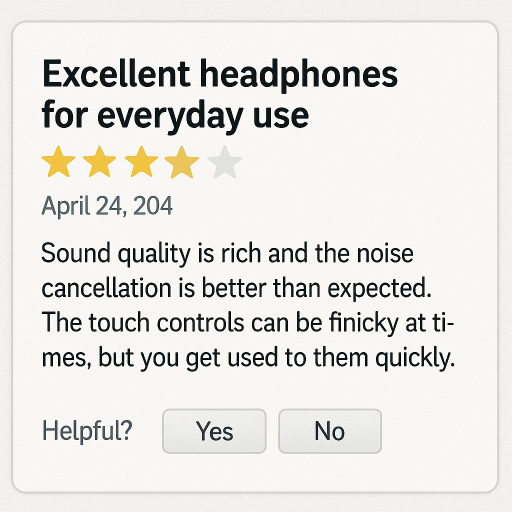


In [ ]:
# Definiamo un system prompt che specifica che il modello deve classificare le recensioni come positive o negative.
system_prompt = "You are a helpful assistant that classifies product reviews as either \"positive\" or \"negative\" based on their content. Always respond with just one word: \"positive\" or \"negative\"."

# Definiamo una funzione che genera un prompt da una recensione.
def prompt_from_review(title,content):
    return f"Classify the sentiment of the following Amazon review.\nTitle: {title}\nContent: {content}"

# Proviamo con una recensione positiva.
review_title = "Excellent headphones for everyday use"
review_content = "Sound quality is rich and the noise cancellation is better than expected. The touch controls can be finicky at times, but you get used to them quickly."

prompt = prompt_from_review(review_title, review_content)

print(generate_response(base_model, tokenizer, prompt, system_prompt))

Abbiamo usato una recensione complessivamente positiva, ma il nostro modello la classifica come negativa. Notiamo anche che il system prompt non è stato recepito del tutto: ci risponde con la sola classificazione ("Negative"), anche se gli abbiamo chiesto di rispondere con "positive" o "negative" lowercase.

## Dataset
Per addestrare il modello, abbiamo bisogno di un dataset.

Per questo esempio, useremo un dataset di recensioni di prodotti Amazon, utilizzando un dataset disponibile online, chiamato [fancyzhx/amazon_polarity](https://huggingface.co/datasets/fancyzhx/amazon_polarity). Questo dataset contiene 3M di recensioni di prodotti Amazon, etichettate come positive o negative.

Per caricare il dataset, usiamo la funzione `load_dataset` di Hugging Face.

In [ ]:
# Importiamo la funzione load_dataset dalla libreria di hugging face
from datasets import load_dataset
import json

In [ ]:
# Carichiamo il dataset. Questo innescherà un download dalla repository di hugging face.
dataset = load_dataset("fancyzhx/amazon_polarity")
print("Dataset loaded:\n", dataset)
print("Dataset[train][0]:\n", json.dumps(dataset["train"][0], indent=2))

# Notare che l'oggetto dataset è un oggetto python di tipo Dataset, già diviso in training set e validation set.
# Questo oggetto ha diverse funzioni di utilità.

Ottimo, abbiamo il nostro dataset. Ora dobbiamo prepararlo per il training, rimappando i dati nel formato che il modello si aspetta, ovvero in formato chat.

Definiamo la funzione di mapping:


In [ ]:
## Definiamo una funzione che, a partire dagli esempi del dataset, li rimappa nel formato atteso dal LM (chat) e lo tokenizza.
def tokenize_function(examples):
    prompts = []
    for title, content, label in zip(examples['title'], examples['content'], examples['label']):
        prompt = prompt_from_review(title, content)
        response = "positive" if label == 1 else "negative"
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt},
            {"role": "assistant", "content": response}
        ]
        formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False)
        prompts.append(formatted_prompt)
    return tokenizer(prompts, truncation=True, padding="max_length", max_length=512)

💡💡💡💡 inizio parte Opzionale
<h2>Riduzione del dataset</h2>
Per velocizzare l'operazione di mapping possiamo ridurre la dimensione del dataset.
Dobbiamo però sapere quanti esempi verrano utilizzati durante il training.

Il numero di esempi che verranno processati è dato da questo prodotto:
`per_device_train_batch_size * gradient_accumulation_steps * max_steps`
Questa è la dimensione di quella che si chiama Epoca, ovvero un ciclo completo di traning sull'intero dataset.

Nel nostro caso i valori sono:

```
per_device_train_batch_size=4,
gradient_accumulation_steps=8,
max_steps=100
```
Nel nostro caso quindi un epoca corrisponde a 4x8x100= 3200 esempi.

Per il validation set usiamo aribitrariamente 200 esempi per ridurre i tempi di traning.

In [ ]:
small_train = dataset["train"].select(range(3200))
small_test = dataset["test"].select(range(200))

dataset["train"] = small_train;
dataset["test"] = small_test;

💡💡💡💡 fine parte Opzionale

Bene, ora possimao procedere con il mapping del dataset:

In [ ]:
dataset = dataset.map(tokenize_function, batched=True)

## Training

Siamo pronti con dataset e modello base. Iniziamo!

Per effettuare il fine-tuning, useremo una tecnica chiamata Supervised Fine Tuning, tramite la libreria trl di Hugging Face.

In questo modo è possibile insegnare a un modello basilare tramite dei dataset curati a svolgere alcuni task specifici, come in questo caso.

In [ ]:
# Importiamo la libreria
from trl import SFTTrainer
from transformers import TrainingArguments

# Definiamo i parametri del training.
# Senza andare troppo nel dettaglio, vediamo cosa fanno alcuni di questi:
training_args = TrainingArguments(
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    # Determina il numero massimo di step, e quanti step ci metterà ad arrivare al learning rate target (vedi sotto)
    warmup_steps=100,
    max_steps=100,
    # Il learning rate indica quanto intensamente applicare gli aggiustamenti basati sugli
    # esempi al dataset.
    # Non esiste un valore perfetto, va valutato in base alla taglia del modello e alla dimensione del dataset.
    # Se si mette troppo alto, rischiamo overfitting o catastrofic forgetting
    # Se troppo basso, rischiamo che il modello non apprenda dal dataset
    # 2e-5 per un modello "piccolo" è abbastanza standard. Range accettabile: 1e-5 ~ 5e-5
    learning_rate=2e-5,
    optim="adamw_torch",
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    # Questo è il valore del seed del generatore di numeri casuali. Lo fissiamo a un numero scelto per evitare che
    # ripetendo il training si ottengano risultati diversi
    seed=3407,
    output_dir="outputs",
    logging_dir="outputs/logs",
    # Questi due servono a indicare dove salvare gli step intermedi di training e ogni quanti step salvare
    logging_strategy="steps",
    logging_steps=5,
    eval_strategy="steps",
    eval_steps=25,
    save_strategy="steps",
    save_steps=100,
    report_to="none"
)

# Instanziamo la classe del trainer, passandogli i parametri
# Il trainig modifica il modello passato come parametro, vogliamo mantenere il modello originale per fare dei confronti dopo il tuninig.
# Ricarichiamo quindi il modello iniziale e salviamolo in finetune_model che sarà l'ouput del nostro traning.
finetuned_model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=base_model_name
).to(device)

trainer = SFTTrainer(
    model=finetuned_model,
    processing_class=tokenizer,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    args=training_args,
)

Tutto pronto, si parte!
Addestriamo il nostro modello...

In [ ]:
trainer.train()

Come facciamo a vedere com'è andato il nostro training?

Possiamo disegnare qualche grafico:

In [ ]:
import matplotlib.pyplot as plt

# Estrai i log dal trainer
log_history = trainer.state.log_history

# Separa training loss e validation loss
train_logs = [log for log in log_history if "loss" in log and "eval_loss" not in log]
eval_logs = [log for log in log_history if "eval_loss" in log]

# Estrai i valori
train_loss = [log["loss"] for log in train_logs]
eval_loss = [log["eval_loss"] for log in eval_logs]

# Crea gli step corrispondenti
train_steps = [log["step"] for log in train_logs]
eval_steps = [log["step"] for log in eval_logs]

# Crea il plot
plt.figure(figsize=(12, 6))
plt.plot(train_steps, train_loss, marker='o', label='Training Loss', color='blue', linewidth=2)
plt.plot(eval_steps, eval_loss, marker='s', label='Validation Loss', color='red', linewidth=2)

plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

# Opzionale: stampa alcune statistiche
print(f"Training loss finale: {train_loss[-1]:.4f}")
print(f"Validation loss finale: {eval_loss[-1]:.4f}")
print(f"Numero di step di training: {len(train_steps)}")
print(f"Numero di step di validation: {len(eval_steps)}")

La funzione di LOSS è scesa nel tempo, quindi significa che il modello "ha imparato" dagli esempi.

Ok, proviamo a vedere come si comporta sull'esempio di prima:

In [ ]:
# Proviamo ad eseguirlo sull'esempio di prima
prompt = prompt_from_review(review_title, review_content)
print(generate_response(finetuned_model, tokenizer, prompt, system_prompt))

Buono! La classificazione funziona!

## Test
Proviamo con altri esempi e confrontiamo con il modello pre fine-tuning.

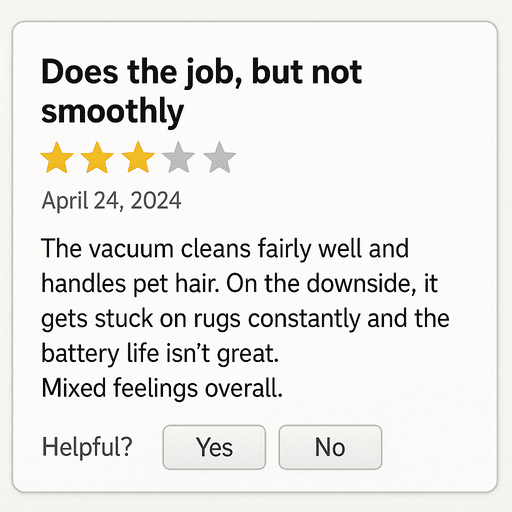

In [ ]:
review_title = "Does the job, but not smoothly"
review_content = "The vacuum cleans fairly well and handles pet hair. On the downside, it gets stuck on rugs constantly and the battery life isn’t great. Mixed feelings overall."
prompt = prompt_from_review(review_title, review_content)

print("Review Title:")
print(review_title)
print("Review Content:")
print(review_content)
print("--------")
print("Base Model prediction:")
print(generate_response(base_model, tokenizer, prompt, system_prompt))
print("--------")
print("Fine-Tuned Model prediction:")
print(generate_response(finetuned_model, tokenizer, prompt, system_prompt))

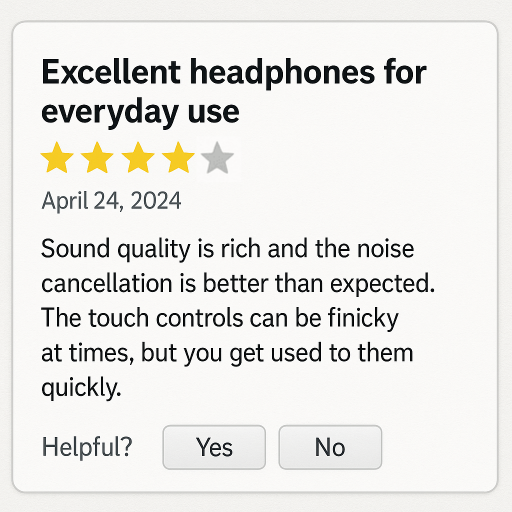

In [ ]:
review_title = "Excellent headphones for everyday use"
review_content = "Sound quality is rich and the noise cancellation is better than expected. The touch controls can be finicky at times, but you get used to them quickly."
prompt = prompt_from_review(review_title, review_content)

print("Review Title:")
print(review_title)
print("Review Content:")
print(review_content)
print("--------")
print("Base Model prediction:")
print(generate_response(base_model, tokenizer, prompt, system_prompt))
print("--------")
print("Fine-Tuned Model prediction:")
print(generate_response(finetuned_model, tokenizer, prompt, system_prompt))

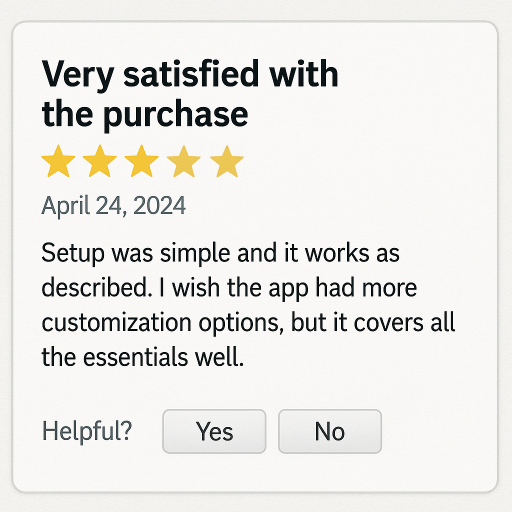

In [ ]:
review_title = "Very satisfied with the purchase"
review_content = "Setup was simple and it works as described. I wish the app had more customization options, but it covers all the essentials well."
prompt = prompt_from_review(review_title, review_content)

print("Review Title:")
print(review_title)
print("Review Content:")
print(review_content)
print("--------")
print("Base Model prediction:")
print(generate_response(base_model, tokenizer, prompt, system_prompt))
print("--------")
print("Fine-Tuned Model prediction:")
print(generate_response(finetuned_model, tokenizer, prompt, system_prompt))

Possiamo vedere che il modello dopo il fine-tuning ha imparato a classificare le recensioni come positive o negative.

Continua con il notebook 02_function_calling.ipynb